# Import Important Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import pickle
from matplotlib.ticker import FixedLocator

# Important Functions

In [3]:
def model_evaluation(y_test, y_pred):
    """
    Evaluate the model's predictions using confusion matrix, classification report,
    and additional performance metrics such as F1-score, TPR, FPR, and accuracy.
    """
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['AI', 'Human'])
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Extract components of the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Safeguard against division by zero for rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print("\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"True Positive Rate (TPR, Sensitivity): {tpr:.2f}")
    print(f"True Negative Rate (TNR, Specificity): {tnr:.2f}")
    print(f"False Positive Rate (FPR): {fpr:.2f}")
    print(f"False Negative Rate (FNR): {fnr:.2f}")

    # Calculate total number of mistakes (false predictions)
    actual_mistakes = fp + fn
    error_rate = actual_mistakes / len(y_pred)

    print("\nTotal Number of Mistakes:", actual_mistakes)
    print(f"Error Rate: {error_rate:.2f}")


In [6]:
def evaluation(X_train, ground_truth_y_train, X_test, ground_truth_y_test, model):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("TRAINING DATASET")
    model_evaluation(ground_truth_y_train, y_pred_train)
    print("\nTESTING DATASET")
    model_evaluation(ground_truth_y_test, y_pred_test)

In [7]:
def testing(text, model):
    label_mapping = {0: 'Human', 1: 'AI'}
    embeded_text = processed_dataset_obj.preprocessing_text(text).reshape(1, -1)
    embeded_text_df = pd.DataFrame(embeded_text)
    embeded_text_df.columns = [f"feature_{i}" for i in range(1, embeded_text_df.shape[1] + 1)]
    transformed_data = fdr.transform_single_data_point(embeded_text_df)
    prediction = model.predict(transformed_data)
    predicted_label = label_mapping[prediction[0]] + " Generated"
    return predicted_label

In [8]:
def count_plot(dataset):

    # Define the label mapping with integer keys
    label_mapping = {0: 'Human', 1: 'AI'}
    
    # Create the countplot
    ax = sns.countplot(x='label', data=dataset)
    
    # Set fixed ticks and tick labels based on the mapping
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    ax.set_xticklabels([label_mapping[int(label.get_text())] for label in ax.get_xticklabels()])
    
    # Annotate each bar with the count
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # The count value
            (p.get_x() + p.get_width() / 2, p.get_height()),  # Position of the text
            ha='center',
            va='bottom'
        )
    ax.set_xlabel('Category')  
    ax.set_ylabel('Count')     
    
    # Show the plot
    plt.show()

# Loading Dataset

In [9]:
def get_dataset_df(human_dataset_path, ai_dataset_path):
    dataset_paths = [human_dataset_path, ai_dataset_path]
    result_df = pd.DataFrame()
    
    for dataset_path in dataset_paths:

        label = 1 if dataset_path.split('\\')[-1] == 'AI' else 0 ## 1 for AI generated text and 0 for human generated text
        
        csv_files = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) 
                if file_name.endswith(".csv")]
        
        for csv_file in csv_files:
            data = pd.read_csv(csv_file)
            data['label'] = label
            result_df = pd.concat([result_df, data], ignore_index=True)
    result_df = result_df.drop(columns = ['uid'])
    result_df = result_df.drop_duplicates()
    result_df = result_df.sample(frac=1).reset_index(drop=True)
            
    return result_df

In [10]:
ai_dataset_path = r"Dataset\AI"
human_dataset_path = r"Dataset\Human"
dataset = get_dataset_df(human_dataset_path, ai_dataset_path)

In [11]:
dataset.shape

(58537, 2)

In [12]:
dataset.head()

,text,label
0,"Just a few hours ago, the official Dark Souls ...",1
1,"Late on Thursday night, just minutes before a ...",1
2,"Last week, Liam Byrne, Labour's policy coordin...",1
3,Canadian Tire Corp. Ltd. will take over naming...,1
4,Our goal is to support women who have chosen t...,1


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58537 entries, 0 to 58536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    58537 non-null  object
 1   label   58537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 914.8+ KB


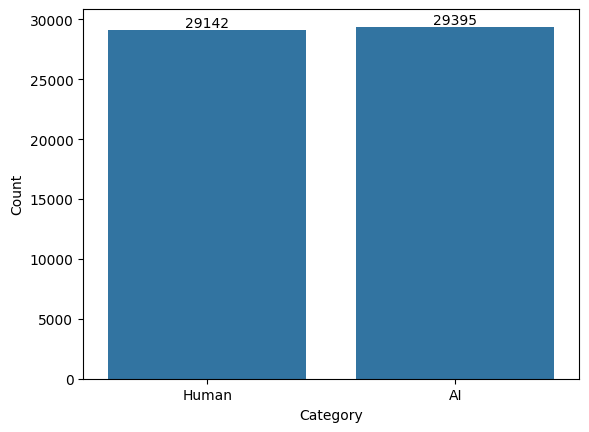

In [14]:
count_plot(dataset)

# Selecting 10000 smaples with equal class

In [15]:
dataset.shape

(58537, 2)

In [16]:
def sampling_the_dataset(dataset, num_samples, random_state=42):
    class_0_samples = num_samples//2
    class_1_samples = num_samples - class_0_samples
    
    dataset_0 = dataset[dataset['label'] == 0]
    sampled_dataset_0 = dataset_0.sample(class_0_samples, random_state=random_state)
    
    dataset_1 = dataset[dataset['label'] == 1]
    sampled_dataset_1 = dataset_1.sample(class_1_samples, random_state=random_state)

    combined_dataset = pd.concat([sampled_dataset_0, sampled_dataset_1], axis=0, ignore_index=True)

    shuffled_dataset = combined_dataset.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return shuffled_dataset

In [17]:
dataset_25000 = sampling_the_dataset(dataset,25000)

In [18]:
dataset_25000.shape

(25000, 2)

In [19]:
dataset_25000.head()

,text,label
0,"Nic MacBean: friend, colleague, bloody good jo...",0
1,Patients who have been taking opioids for an e...,1
2,The other day in the shower (always the best p...,0
3,"Back in 1958, while Fidel Castro was planning ...",1
4,Elexis Webster was placed in foster care at th...,1


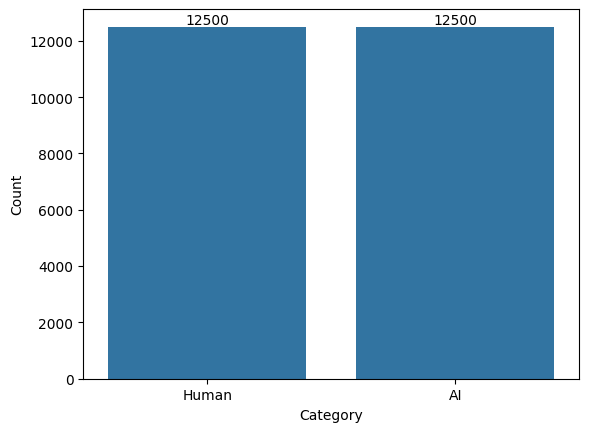

In [20]:
count_plot(dataset_25000)

# Dataset Preprocessing

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
# X = dataset.drop(columns = ['label'])
X = dataset_25000['text']
y = dataset_25000['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
print(f"Training dataset : \n  Features shape - {X_train.shape} \n  Target shape - {y_train.shape}")
print(f"Testing dataset : \n  Features shape - {X_test.shape} \n  Target shape - {y_test.shape}")

Training dataset : 
  Features shape - (20000,) 
  Target shape - (20000,)
Testing dataset : 
  Features shape - (5000,) 
  Target shape - (5000,)


In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

TfidfVectorizer()

In [26]:
X_train_transformed = tfidf_vectorizer.transform(X_train)

In [27]:
X_train_transformed.shape

(20000, 129996)

In [43]:
print(tfidf_vectorizer.get_feature_names_out())

['00' '000' '0000' ... 'zzzz' 'zzzzs' 'zzzzzz']


In [44]:
print(len(tfidf_vectorizer.get_feature_names_out()))

194531


In [45]:
tr = tfidf_vectorizer.transform(X_train[:10])

In [28]:
X_test_transformed = tfidf_vectorizer.transform(X_test)

# Data Tarnsformation and Spliting

In [5]:
preprocessed_data = pd.read_pickle('Dataset\preprocessed_gpt2_data_10000.pkl')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [41]:
class FeaturesDimensionalityReduction:
    def __init__(self, scaler=None, pca=None):
        self.scaler = scaler or StandardScaler()
        self.pca = pca or PCA()

    def fit(self, X_data, n_components):
        self.scaler.fit(X_data)
        standardized_data = self.scaler.transform(X_data)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(standardized_data)

    def transform_data(self, data):
        standardized_data = self.scaler.transform(data)
        return self.pca.transform(standardized_data)

    def transform_single_data_point(self, data_point):
        return self.transform_data(data_point)

    def save(self, scaler_path="scaler.pkl", pca_path="pca.pkl"):
        with open(scaler_path, "wb") as scaler_file:
            pickle.dump(self.scaler, scaler_file)
        with open(pca_path, "wb") as pca_file:
            pickle.dump(self.pca, pca_file)

    def load(self, scaler_path="scaler.pkl", pca_path="pca.pkl"):
        with open(scaler_path, "rb") as scaler_file:
            self.scaler = pickle.load(scaler_file)
        with open(pca_path, "rb") as pca_file:
            self.pca = pickle.load(pca_file)

In [42]:
preprocessed_data.shape

(10000, 769)

In [43]:
X = preprocessed_data.drop(columns = ['label'])
y = preprocessed_data['label']

In [44]:
X.shape

(10000, 768)

In [46]:
fdr = FeaturesDimensionalityReduction()
fdr.fit(X, 100)


In [47]:
transformed_X_data = fdr.transform_data(X)

In [54]:
transformed_X_data[0][:5]

array([ 6.9083366, -5.462002 , -8.965607 ,  5.713791 , -1.197024 ],
      dtype=float32)

In [49]:
# fdr.save(scaler_path="Model\scaler.pkl", pca_path="Model\pca.pkl")

In [50]:
# fdr.load(scaler_path="Model\scaler.pkl", pca_path="Model\pca.pkl")

In [48]:
transformed_X_data.shape

(10000, 100)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(tr_x, y, test_size=0.20, random_state=42)

In [56]:
print(f"Training dataset : \n  Features shape - {X_train.shape} \n  Target shape - {y_train.shape}")
print(f"Testing dataset : \n  Features shape - {X_test.shape} \n  Target shape - {y_test.shape}")

Training dataset : 
  Features shape - (8000, 100) 
  Target shape - (8000,)
Testing dataset : 
  Features shape - (2000, 100) 
  Target shape - (2000,)


# Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
# logistic_regression_model = LogisticRegression(solver='sag', max_iter = 1000)
logistic_regression_model = LogisticRegression()

In [65]:
logistic_regression_model.fit(X_train_transformed, y_train)

LogisticRegression()

In [66]:
# y_pred_test = logistic_regression_model.predict(X_test_transformed)
# y_pred_train = logistic_regression_model.predict(X_train_transformed)

TRAINING DATASET


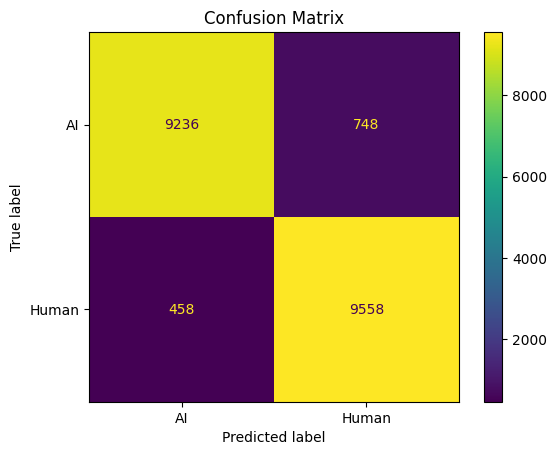


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      9984
           1       0.93      0.95      0.94     10016

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Additional Metrics:
Accuracy: 0.94
F1-score: 0.94
True Positive Rate (TPR, Sensitivity): 0.95
True Negative Rate (TNR, Specificity): 0.93
False Positive Rate (FPR): 0.07
False Negative Rate (FNR): 0.05

Total Number of Mistakes: 1206
Error Rate: 0.06

TESTING DATASET


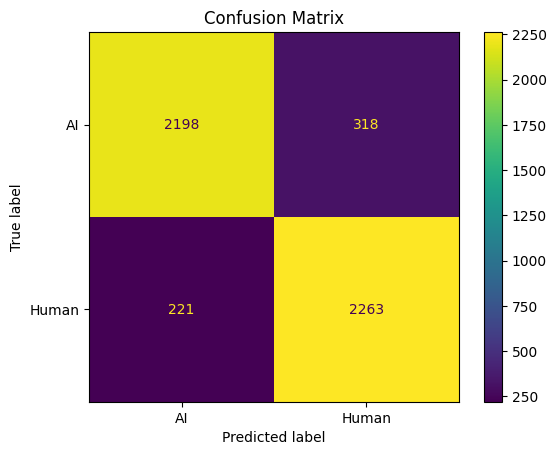


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2516
           1       0.88      0.91      0.89      2484

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000


Additional Metrics:
Accuracy: 0.89
F1-score: 0.89
True Positive Rate (TPR, Sensitivity): 0.91
True Negative Rate (TNR, Specificity): 0.87
False Positive Rate (FPR): 0.13
False Negative Rate (FNR): 0.09

Total Number of Mistakes: 539
Error Rate: 0.11


In [67]:
evaluation(X_train_transformed, y_train, X_test_transformed, y_test, logistic_regression_model)

In [26]:
# Save the model
# with open("Model\logistic_regression_model.pkl", "wb") as file:
    # pickle.dump(logistic_regression_model, file)

In [28]:
# Load the model
with open("Model\logistic_regression_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

In [29]:
new_dataset = """
with due respect what 
"""

In [39]:
pred = testing(new_dataset, loaded_model)

In [40]:
print(pred)

Human Generated


In [94]:
a = np.array([0])
a

array([0])

In [95]:
label_mapping = {0: 'Human', 1: 'AI'} 
label_mapping

{0: 'Human', 1: 'AI'}

In [98]:
label_mapping[a[0]]

'Human'

In [96]:
a[0]

0

# Naive Bayes 

In [69]:
from sklearn.naive_bayes import GaussianNB

In [70]:
guassianNB_classifier = GaussianNB()

In [73]:
# guassianNB_classifier.fit(X_train_transformed.toarray(), y_train)

In [ ]:
y_pred_test = logistic_regression_model.predict(X_test_transformed)
y_pred_train = logistic_regression_model.predict(X_train_transformed)

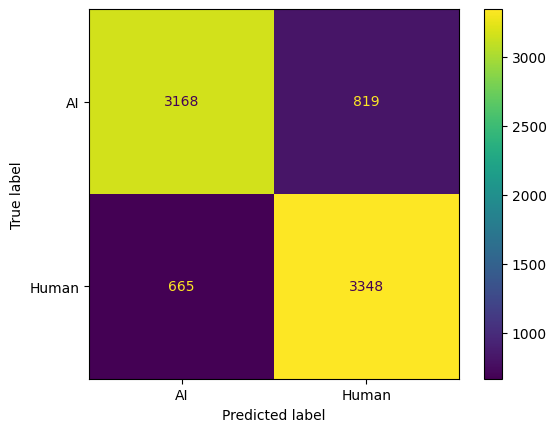


Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      3987
           1       0.80      0.83      0.82      4013

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.21
False Negative Rate (FNR): 0.17
True Positive Rate (TPR): 0.83
True Negative Rate (TNR): 0.79

Summary of Errors:
Total Mistakes (FP + FN): 1484
Error Rate: 0.19


In [117]:
y_pred_train = guassianNB_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

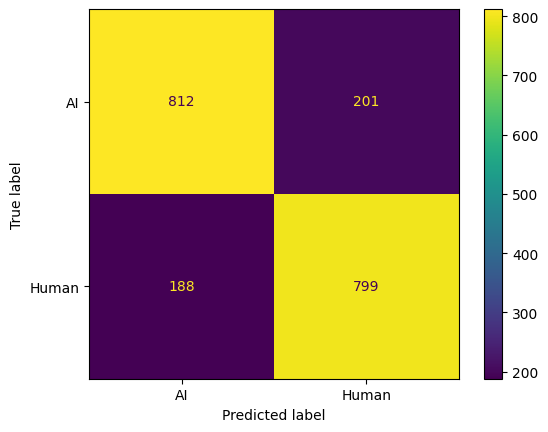


Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1013
           1       0.80      0.81      0.80       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.20
False Negative Rate (FNR): 0.19
True Positive Rate (TPR): 0.81
True Negative Rate (TNR): 0.80

Summary of Errors:
Total Mistakes (FP + FN): 389
Error Rate: 0.19


In [118]:
y_pred_test = guassianNB_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

# Support Vector Machine

In [34]:
from sklearn.svm import SVC

In [35]:
svm_classifier = SVC()

In [36]:
svm_classifier.fit(X_train_transformed, y_train)

SVC()

TRAINING DATASET


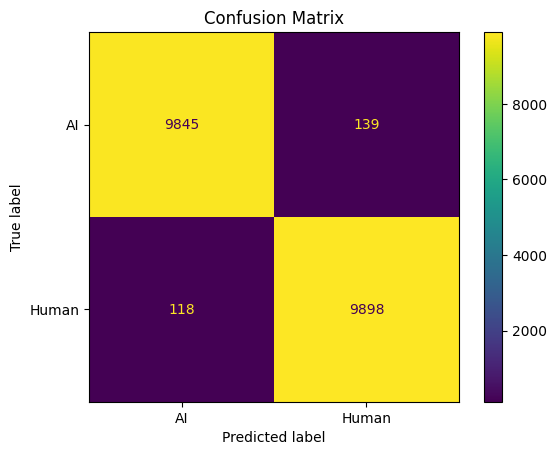


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      9984
           1       0.99      0.99      0.99     10016

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000


Additional Metrics:
Accuracy: 0.99
F1-score: 0.99
True Positive Rate (TPR, Sensitivity): 0.99
True Negative Rate (TNR, Specificity): 0.99
False Positive Rate (FPR): 0.01
False Negative Rate (FNR): 0.01

Total Number of Mistakes: 257
Error Rate: 0.01

TESTING DATASET


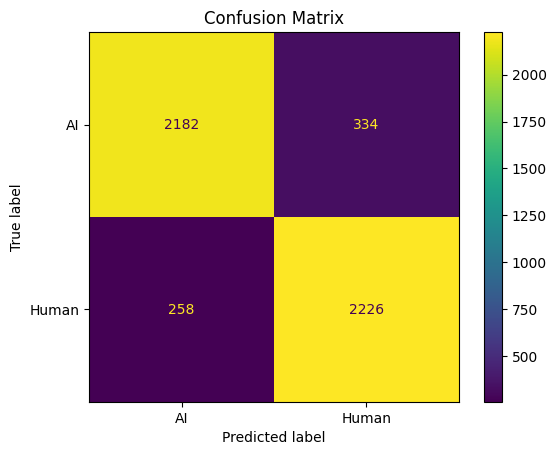


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2516
           1       0.87      0.90      0.88      2484

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000


Additional Metrics:
Accuracy: 0.88
F1-score: 0.88
True Positive Rate (TPR, Sensitivity): 0.90
True Negative Rate (TNR, Specificity): 0.87
False Positive Rate (FPR): 0.13
False Negative Rate (FNR): 0.10

Total Number of Mistakes: 592
Error Rate: 0.12


In [37]:
evaluation(X_train_transformed, y_train, X_test_transformed, y_test, svm_classifier)

# Random Forest Model

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
# from sklearn.model_selection import cross_val_score

In [40]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [41]:
random_forest_classifier = RandomForestClassifier()

In [42]:
random_forest_classifier.fit(X_train_transformed, y_train)

RandomForestClassifier()

TRAINING DATASET


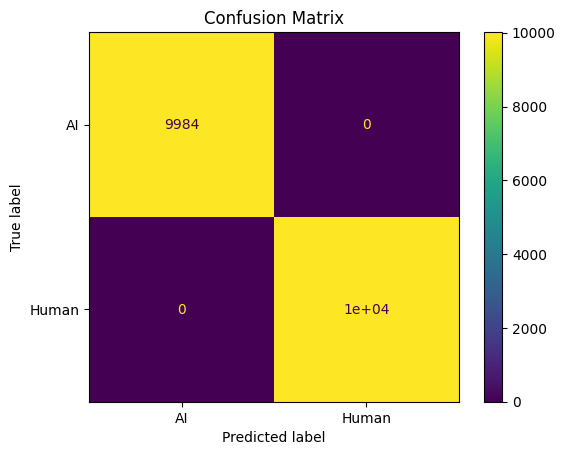


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9984
           1       1.00      1.00      1.00     10016

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Additional Metrics:
Accuracy: 1.00
F1-score: 1.00
True Positive Rate (TPR, Sensitivity): 1.00
True Negative Rate (TNR, Specificity): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00

Total Number of Mistakes: 0
Error Rate: 0.00

TESTING DATASET


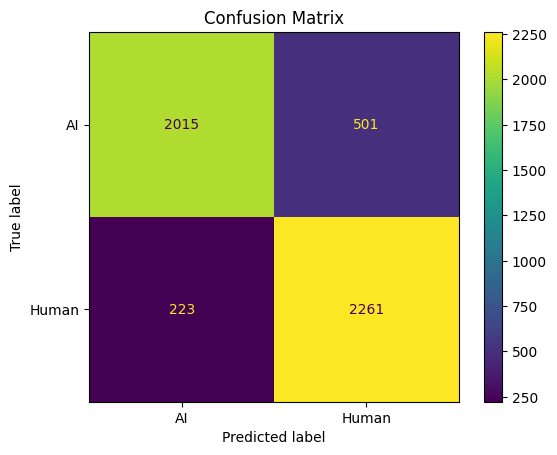


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      2516
           1       0.82      0.91      0.86      2484

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.85      5000
weighted avg       0.86      0.86      0.85      5000


Additional Metrics:
Accuracy: 0.86
F1-score: 0.86
True Positive Rate (TPR, Sensitivity): 0.91
True Negative Rate (TNR, Specificity): 0.80
False Positive Rate (FPR): 0.20
False Negative Rate (FNR): 0.09

Total Number of Mistakes: 724
Error Rate: 0.14


In [44]:
evaluation(X_train_transformed, y_train, X_test_transformed, y_test, random_forest_classifier)

In [43]:
param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(10, 70),
    'min_samples_split': Integer(2, 20),
    'criterion' : ('gini', 'entropy', 'log_loss')
}

In [24]:
bayes_search = BayesSearchCV(
    estimator=random_forest_classifier,
    search_spaces=param_space,
    n_iter=1,                  
    cv=5,                       
    scoring='accuracy',         
    random_state=42,
    verbose = 1
)


In [ ]:
bayes_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [179]:
cv_results = pd.DataFrame(bayes_search.cv_results_)

In [180]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.580787,0.145036,0.015399,0.001358,entropy,50,20,100,"{'criterion': 'entropy', 'max_depth': 50, 'min...",0.82500,0.85625,0.84375,0.84375,0.81250,0.83625,0.015512,15
1,6.756424,0.286201,0.039188,0.005033,log_loss,70,2,250,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81875,0.85625,0.86875,0.81875,0.80000,0.83250,0.025739,17
2,4.273878,0.312250,0.023393,0.001959,entropy,70,2,150,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.81875,0.84375,0.87500,0.80000,0.85000,0.83750,0.025921,14
3,6.530433,0.256340,0.035178,0.001466,log_loss,10,10,250,"{'criterion': 'log_loss', 'max_depth': 10, 'mi...",0.84375,0.85000,0.88125,0.83125,0.82500,0.84625,0.019605,5
4,5.303402,0.162794,0.030587,0.004119,log_loss,25,10,200,"{'criterion': 'log_loss', 'max_depth': 25, 'mi...",0.82500,0.86250,0.85625,0.83750,0.82500,0.84125,0.015612,9
5,1.268390,0.012591,0.008198,0.000748,log_loss,70,2,50,"{'criterion': 'log_loss', 'max_depth': 70, 'mi...",0.81250,0.81250,0.81875,0.81875,0.83750,0.82000,0.009186,24
6,6.656054,0.266005,0.035189,0.002322,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.85000,0.86875,0.89375,0.82500,0.84375,0.85625,0.023385,1
7,6.484534,0.125587,0.040384,0.011017,entropy,70,10,250,"{'criterion': 'entropy', 'max_depth': 70, 'min...",0.83750,0.85625,0.85625,0.81875,0.83125,0.84000,0.014577,12
8,3.836771,0.351215,0.022989,0.003623,log_loss,50,20,150,"{'criterion': 'log_loss', 'max_depth': 50, 'mi...",0.84375,0.86875,0.86875,0.82500,0.81250,0.84375,0.022707,6
9,2.201889,0.017471,0.015196,0.000400,gini,70,20,100,"{'criterion': 'gini', 'max_depth': 70, 'min_sa...",0.84375,0.83750,0.84375,0.79375,0.81250,0.82625,0.019922,22


In [178]:
print("val. score: ", bayes_search.best_score_)
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.85625
test score:  0.835
best params:  OrderedDict([('criterion', 'entropy'), ('max_depth', 70), ('min_samples_split', 10), ('n_estimators', 250)])


In [181]:
y_pred_test = bayes_search.predict(X_test)

In [134]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [ ]:
y_pred_test = bayes_search.predict(X_test_transformed)
y_pred_train = bayes_search.predict(X_train_transformed)

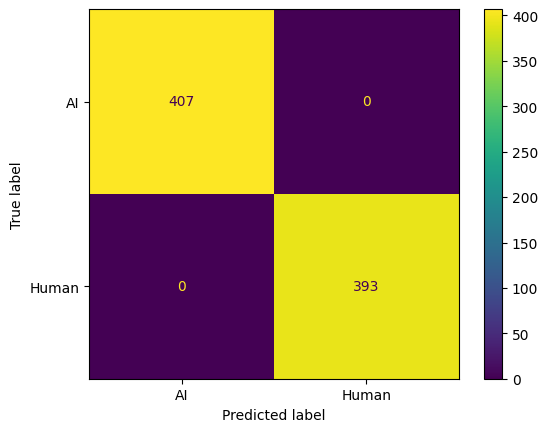


Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       393

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [184]:
model_evaluation(y_train, y_pred_train)

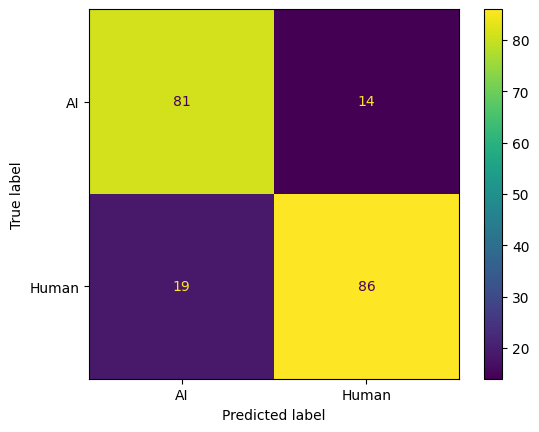


Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        95
           1       0.86      0.82      0.84       105

    accuracy                           0.83       200
   macro avg       0.83      0.84      0.83       200
weighted avg       0.84      0.83      0.84       200


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.15
False Negative Rate (FNR): 0.18
True Positive Rate (TPR): 0.82
True Negative Rate (TNR): 0.85

Summary of Errors:
Total Mistakes (FP + FN): 33
Error Rate: 0.17


In [183]:
model_evaluation(y_test, y_pred_test)

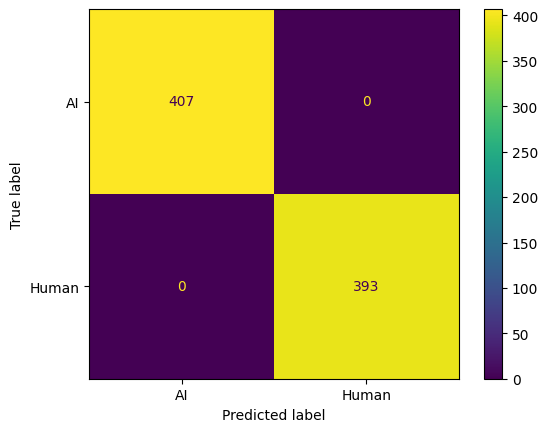

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       1.00      1.00      1.00       393

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 1.00

Summary of Errors:
Total Mistakes (FP + FN): 0
Error Rate: 0.00


In [135]:
y_pred_train = random_forest_classifier.predict(X_train)
model_evaluation(y_train, y_pred_train)

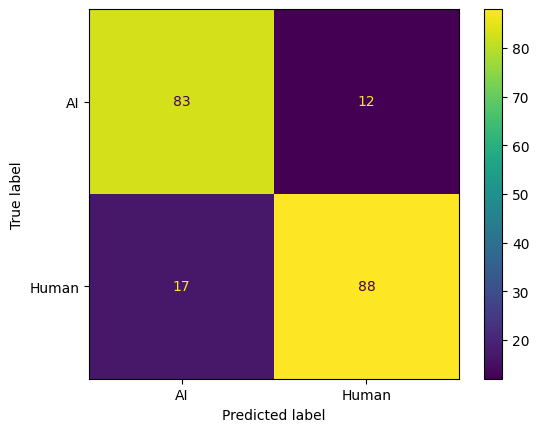

Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        95
           1       0.88      0.84      0.86       105

    accuracy                           0.85       200
   macro avg       0.85      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200


Error Rates and Additional Analysis:
False Positive Rate (FPR): 0.13
False Negative Rate (FNR): 0.16
True Positive Rate (TPR): 0.84
True Negative Rate (TNR): 0.87

Summary of Errors:
Total Mistakes (FP + FN): 29
Error Rate: 0.14


In [136]:
y_pred_test = random_forest_classifier.predict(X_test)
model_evaluation(y_test, y_pred_test)

# XGBoost 

In [45]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [46]:
xgboost_classifier = XGBClassifier()

In [47]:
xgboost_classifier.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

TRAINING DATASET


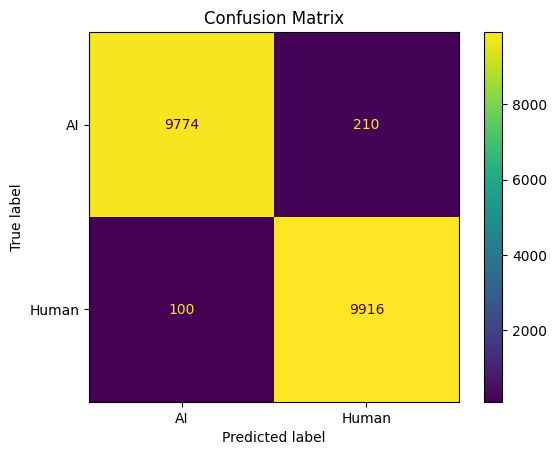


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      9984
           1       0.98      0.99      0.98     10016

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Additional Metrics:
Accuracy: 0.98
F1-score: 0.98
True Positive Rate (TPR, Sensitivity): 0.99
True Negative Rate (TNR, Specificity): 0.98
False Positive Rate (FPR): 0.02
False Negative Rate (FNR): 0.01

Total Number of Mistakes: 310
Error Rate: 0.02

TESTING DATASET


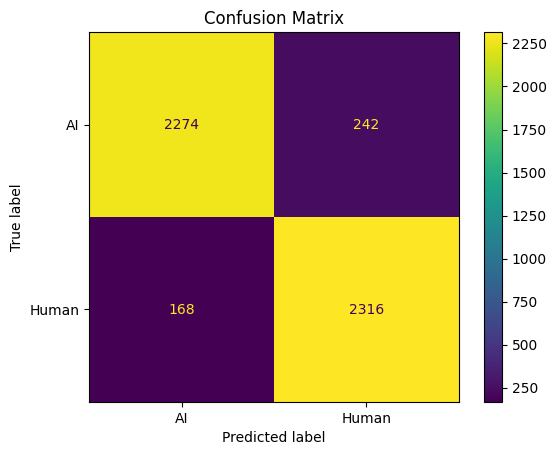


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      2516
           1       0.91      0.93      0.92      2484

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000


Additional Metrics:
Accuracy: 0.92
F1-score: 0.92
True Positive Rate (TPR, Sensitivity): 0.93
True Negative Rate (TNR, Specificity): 0.90
False Positive Rate (FPR): 0.10
False Negative Rate (FNR): 0.07

Total Number of Mistakes: 410
Error Rate: 0.08


In [48]:
evaluation(X_train_transformed, y_train, X_test_transformed, y_test, xgboost_classifier)

In [134]:
# Define the parameter search space
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.3, 1.0),
    'gamma': Real(0, 0.5),
    'reg_alpha': Real(0, 1.0),
    'reg_lambda': Real(0, 1.0),
    'min_child_weight': Integer(1, 10),
    
}

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=xgboost_classifier,
    search_spaces=search_spaces,
    scoring='accuracy', 
    cv=5,
    n_iter=25,  
    verbose=0,
    random_state=42
)

# Fit to the training data
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=1.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')})

In [217]:
print("val. score: ", bayes_search.best_score_) #10 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.85375
test score:  0.865
best params:  OrderedDict([('colsample_bytree', 0.8596874091250211), ('gamma', 0.21901459322046168), ('learning_rate', 0.05996280567850356), ('max_depth', 8), ('min_child_weight', 9), ('n_estimators', 158), ('reg_alpha', 0.42417807246068207), ('reg_lambda', 0.6502841017477626), ('subsample', 0.7412335382111885)])


In [219]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.865
test score:  0.875
best params:  OrderedDict([('colsample_bytree', 0.7098159680567573), ('gamma', 0.4325903537768684), ('learning_rate', 0.11911146809554733), ('max_depth', 10), ('min_child_weight', 4), ('n_estimators', 200), ('reg_alpha', 0.19045293322755044), ('reg_lambda', 1.0), ('subsample', 0.8851384179544988)])


In [221]:
print("val. score: ", bayes_search.best_score_) #60 iter
print("test score: ", bayes_search.score(X_test, y_test))
print("best params: ", bayes_search.best_params_)

val. score:  0.8675
test score:  0.84
best params:  OrderedDict([('colsample_bytree', 0.7598166505204225), ('gamma', 0.5), ('learning_rate', 0.08580281705462359), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('subsample', 1.0)])


In [135]:
print("val. score: ", bayes_search.best_score_) #25 iter
print("test score: ", bayes_search.score(X_test, y_test)) 
print("best params: ", bayes_search.best_params_)

val. score:  0.9037499999999999
test score:  0.9135
best params:  OrderedDict([('colsample_bytree', 0.9981051707664326), ('gamma', 0.469819076944712), ('learning_rate', 0.14652183363667018), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 0.8999343276827675), ('reg_lambda', 0.07026580469678426), ('subsample', 0.6524891243612454)])


In [136]:
best_model = bayes_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9981051707664326, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.469819076944712,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14652183363667018,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [138]:
best_model.score(X_train, y_train)

0.999625

# MLP Classifier

In [49]:
from sklearn.neural_network import MLPClassifier

In [58]:
mlp_classifier = MLPClassifier(hidden_layer_sizes = (1000, 100), 
                               max_iter=5, 
                               random_state=1,
                               verbose = 1,
                              )

In [59]:
mlp_classifier.fit(X_train_transformed, y_train)

C:\Users\HP\anaconda3\envs\MyProject\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(1000, 100), max_iter=5, random_state=1,
              verbose=1)

In [54]:
mlp_classifier.fit(X_train_transformed, y_train)

Iteration 1, loss = 0.46093932
Iteration 2, loss = 0.10614754
Iteration 3, loss = 0.03487786
Iteration 4, loss = 0.02063204
Iteration 5, loss = 0.01091588


C:\Users\HP\anaconda3\envs\MyProject\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=5, random_state=1,
              verbose=1)

TRAINING DATASET


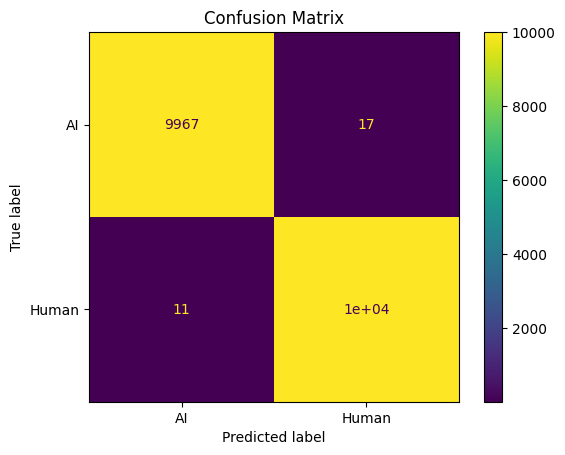


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9984
           1       1.00      1.00      1.00     10016

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Additional Metrics:
Accuracy: 1.00
F1-score: 1.00
True Positive Rate (TPR, Sensitivity): 1.00
True Negative Rate (TNR, Specificity): 1.00
False Positive Rate (FPR): 0.00
False Negative Rate (FNR): 0.00

Total Number of Mistakes: 28
Error Rate: 0.00

TESTING DATASET


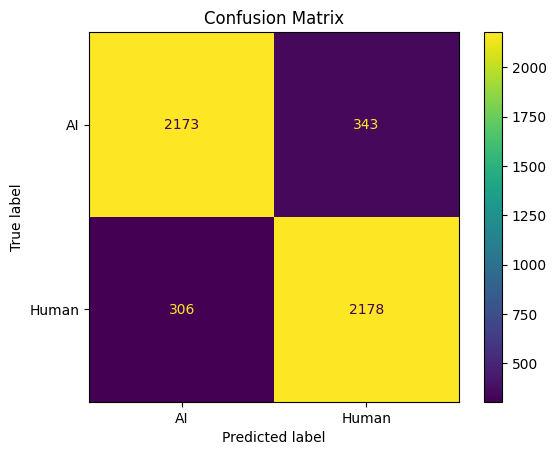


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2516
           1       0.86      0.88      0.87      2484

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000


Additional Metrics:
Accuracy: 0.87
F1-score: 0.87
True Positive Rate (TPR, Sensitivity): 0.88
True Negative Rate (TNR, Specificity): 0.86
False Positive Rate (FPR): 0.14
False Negative Rate (FNR): 0.12

Total Number of Mistakes: 649
Error Rate: 0.13


In [55]:
evaluation(X_train_transformed, y_train, X_test_transformed, y_test, mlp_classifier)

# Explainable AI using LIME

In [60]:
import lime

In [61]:
# Create a LIME text explainer
from lime.lime_text import LimeTextExplainer

class_names = ["human", "AI"]  # 1 for AI and 0 for Human
explainer = LimeTextExplainer(class_names=class_names)

In [85]:
#Custome Testing!

X_test_new = '''World War II, which lasted from 1939 to 1945, was one of the most significant and devastating
conflicts in human history, involving the vast majority of the world's nations, including all of the
great powers, eventually forming two opposing military alliances: the Allies and the Axis. The
war began on September 1, 1939, when Germany, under the leadership of Adolf Hitler, invaded
Poland. This act prompted Britain and France to declare war on Germany. The conflict soon
expanded as Germany, Italy, and Japan sought territorial expansion, leading to widespread
global conflict.
In Europe, Germany's blitzkrieg tactics led to the rapid conquest of several countries. France fell
in 1940, and Britain endured the prolonged Battle of Britain, successfully resisting German air
assaults. Meanwhile, in Eastern Europe, Germany invaded the Soviet Union in 1941, initiating a
brutal and prolonged conflict on the Eastern Front. The war in the Pacific was marked by the
Japanese attack on Pearl Harbor on December 7, 1941, which led to the United States entering
the war. The Pacific theater saw fierce battles across numerous islands, with significant naval
engagements such as the Battle of Midway in 1942, which marked a turning point in favor of the
Allies.
The Holocaust, the systematic genocide of six million Jews and millions of other minorities by
Nazi Germany, remains one of the most horrific aspects of World War II. The war also saw
significant advances in technology and warfare, including the development and use of tanks,
aircraft, and eventually nuclear weapons. The Allied invasion of Normandy on June 6, 1944,
known as D-Day, was a pivotal moment that led to the liberation of Western Europe from Nazi
control. The war in Europe ended on May 8, 1945, with the unconditional surrender of Germany.
In the Pacific, the war continued until August 1945, culminating in the United States dropping
atomic bombs on the Japanese cities of Hiroshima and Nagasaki, leading to Japan's surrender
on September 2, 1945.
World War II resulted in an estimated 70-85 million fatalities, making it the deadliest conflict in
human history. The war caused widespread destruction and significant shifts in political power,
leading to the emergence of the United States and the Soviet Union as superpowers and the
beginning of the Cold War. The United Nations was established in the aftermath to promote
international cooperation and prevent future conflicts. The war's legacy continues to influence
global politics, economics, and society, underscoring the profound impact of this monumental
period in history'''



In [83]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('svc', LogisticRegression())
])

In [87]:
lr_pipeline.fit(dataset_25000['text'], dataset_25000['label'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LogisticRegression())])

In [88]:
# X_test_new = np.array(X_test_new).reshape(1,-1)

In [89]:
# X_test_new_transformed = tfidf_vectorizer.transform(X_test_new)

In [90]:
# X_test_new_transformed.shape

In [102]:
# Explain the prediction for the selected instance
exp = explainer.explain_instance(X_test_new, lr_pipeline.predict_proba, num_features=10)
# exp = explainer.explain_instance(X_test_new, pipeline.predict_proba, num_features=10)

In [93]:
# Get the prediction probability
prediction_prob = lr_pipeline.predict_proba([X_test_new])

print(prediction_prob)

[[0.40048317 0.59951683]]


In [97]:
lr_pipeline.predict([X_test_new])

array([1], dtype=int64)

In [103]:
# Print and visualize the explanation

exp.show_in_notebook()


In [104]:


# Print the LIME values sorted by importance
sorted_explanation = sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True)
print("Top features contributing to the prediction:")
for feature, importance in sorted_explanation:
    print(f"Feature: {feature}, Importance: {importance}")

# Optional: print top 10 features
print("\nTop 10 features contributing to the prediction:")
for feature, importance in sorted_explanation[:10]:
    print(f"Feature: {feature}, Importance: {importance}")

Top features contributing to the prediction:
Feature: of, Importance: -0.20560687739660777
Feature: in, Importance: -0.1515805923126133
Feature: significant, Importance: 0.1275694006024661
Feature: on, Importance: -0.060165887609691646
Feature: which, Importance: 0.03931402086709174
Feature: leading, Importance: 0.03586634211930258
Feature: led, Importance: 0.033753474021439564
Feature: United, Importance: -0.028080516937477002
Feature: including, Importance: 0.026712836108336663
Feature: to, Importance: 0.025824802467523642

Top 10 features contributing to the prediction:
Feature: of, Importance: -0.20560687739660777
Feature: in, Importance: -0.1515805923126133
Feature: significant, Importance: 0.1275694006024661
Feature: on, Importance: -0.060165887609691646
Feature: which, Importance: 0.03931402086709174
Feature: leading, Importance: 0.03586634211930258
Feature: led, Importance: 0.033753474021439564
Feature: United, Importance: -0.028080516937477002
Feature: including, Importance: 0